This workbook will show how it's possible to convert between different coordinate systems easily using the PlasmaEquilibriumToolkit and data from a VMEC equilibrium.  All of the methods described here can be easily extended to different equilibrium solvers, such as SPEC.

If you haven't done the iotaplots workbook, make sure you run the first line that adds and installs packages. 

The first command to use libraries and load the file are the same as in iotaplots

In [1]:
using PlasmaEquilibriumToolkit
using VMEC
using NetCDF
using Plots
using LinearAlgebra # LinearAlgebra is a Julia standard package

wout = NetCDF.open("/home/bfaber/projects/julia/jupyter/wout_aten_reactor.nc");
vmec, vmecdata = VMEC.readVmecWout(wout);


The PlasmaEquilibriumToolkit provides an interface for performing coordinate transformations and computing coordinate-dependent derived quantities specialized to magnetic equilibria.  For coordinate transformations, it extends the `CoordinateTransformations` package to magnetic coordinates.  For many applications, what is desired are the 3D Euclidean (Cartesian) components of the vectors, covariant basis vectors, and contravariant basis vectors defined in some coordinate system that depends on the magnetic equilibrium properties.

The magnetic coordinate systems defined by the PlasmaEquilibriumToolkit are all subtypes of the abstract type `MagneticCoordinates`.  The coordinate systems currently defined are all predicated on the existence of magnetic flux surfaces.  The first field is the flux surface label while the remaining two fields are angle-like coordinates.  The currently defined coordinates are `FluxCoordinates`, `PestCoordinates` and `BoozerCoordinates`.  One can obtain the names of the fields with usual `fieldnames` function

In [2]:
fieldnames(PestCoordinates)

(:ψ, :α, :ζ)

or the coordinates definitions can be queried through its docstring

In [3]:
@doc PestCoordinates

```
PestCoordinates{T,A}(ψ::T,α::A,ζ::A) <: MagneticCoordinates
```

Coordinates on a magnetic flux surface, where `ψ` is the toroidal flux divided by 2π in the clockwise direction, `α` is the field line label, and `ζ` is the geometric toroidal angle advancing the clockwise direction.

```
PestCoordinates(ψ,α,ζ::AbstractVector)
```

Generate a `Vector{PestCoordinates}` given by `(ψ,α,ζⱼ)` where `ζⱼ` is the `j`-th entry of `ζ`.

```
PestCoordinates(ψ,α::AbstractVector,ζ::AbstractVector)
```

Generate a grid of `PestCoordinates` given by `(s,αᵢ,ζⱼ)` is the `i`-th entry of `α` and `ζⱼ` is the `j`-th entry of `ζ`.

```
PestCoordinates(ψ,α::AbstractMatrix,ζ::AbstractMatrix)
```

Generate a grid of `PestCoordinates` given by `(ψ,αᵢⱼ,ζᵢⱼ)` where `α(ζ)ᵢⱼ` is the `ij`-entry of the `α(ζ)` matrix.

```
PestCoordinates(ψ::AbstractVector,α::AbstractVector,ζ::AbstractVector)
```

Generate a 3D grid of `PestCoordinates` given by `(ψᵢ,αⱼ,ζₖ)` where `ψᵢ` is the `i`-th entry of `ψ`, `αⱼ` is the `j`-th entry of `α` and `ζₖ` is the `k`-th entry of `ζ`.

```
PestCoordinates(ψ::AbstractVector,α::AbstractMatrix,ζ::AbstractMatrix)
```

Generate a 3D grid of `PestCoordinates` given by `(ψᵢ,αⱼₖ,ζⱼₖ)` where `ψᵢ` is the `i`-th entry of `ψ`, `αⱼₖ(ζⱼₖ)` is the `jk`-th entry of `α(ζ)`.

```
PestCoordinates(ψ::AbstractArray{T,3},α::AbstractArray{T,3},ζ::AbstractArray{T,3})
```

Generate a 3D grid of `PestCoordinates` given by `(ψᵢⱼₖ,αᵢⱼₖ,ζᵢⱼₖ)` where `ψᵢⱼₖ` is the `ijk`-th entry of `ψ`, `αᵢⱼₖ` is the `ijk`-th entry of `α` and  `ζᵢⱼₖ` is the `ijk`-th entry of `ζ`.


Note that the coordinate fields are defined by their Greek symbols, this makes use of Julia's ability to use rendered Greek letters as variables, labels, etc.  To type a Greek letter in the Julia REPL or a compliant editor, type the LaTeX command for the symbol followed by the tab key, e.g. to type the symbol $\psi$ type `\psi <TAB>`.  All data fields of a Julia `struct` can also be referenced by position, in this case $\psi$ is 1, $\alpha$ is 2, $\zeta$ is 3.  They can be set and retrieved with `setfield(x,#,val)` and `val = getfield(x,#)`, where `x` is the coordinate and `#` is the position number of the data field.

Here we introduce the `VmecSurface` type.  Many calculations that assume nested flux surfaces require only data from a specific surface, the `VmecSurface` type is specialized data structure defining quantities on a single flux surface with a memory layout that maximizes efficiency for operations like inverse Fourier transforms.  We will only explore some of the capabilities in this work sheet. We choose a random surface somewhat near the edge of the plasma.

In [4]:
s = 0.8;
vmecSurface = VmecSurface(s, vmec);

The data fields of a `VmecSurface` object have the same labels as the `Vmec` object its derived from, however now the layout is slightly different.  For any quantity that had radial ($s$) dependence, the spline type in the `Vmec` object has been replaced by value of the spline at $s$ **and** by the derivative with respect to $s$.  For Fourier data where `lasym = T`, the data is now represented in a vector of static vectors of length 6, where the first two entries are the `m` and `n` numbers.  If `lasym = F` then it's a vector of static vectors of length 4.

We can see this be inspecting `vmecSurface` data fields:

In [7]:
vmecSurface.iota

2-element StaticArrays.SVector{2, Float64} with indices SOneTo(2):
 0.7512453685998264
 0.12221496728817005

In [8]:
vmecSurface.rmn

128-element Vector{StaticArrays.SVector{4, Float64}}:
 [0.0, 0.0, 10.098227280028865, -0.3199726784805179]
 [0.0, 4.0, 1.6605106770569613, -0.22148767798439994]
 [0.0, 8.0, 0.17126987905254445, 0.009859193134087452]
 [0.0, 12.0, 0.01638393602668115, 0.03157017719930544]
 [0.0, 16.0, -0.0010227376559333063, 0.0033573765614778673]
 [0.0, 20.0, 4.0422154055193156e-5, -0.0007052465293169834]
 [0.0, 24.0, -1.5621012483627462e-5, 3.867891398459165e-5]
 [0.0, 28.0, -2.3700947624967537e-6, 4.156919735643008e-5]
 [0.0, 32.0, 1.4107919190324345e-6, -5.085293174785222e-6]
 [1.0, -32.0, 4.028336460263454e-6, -1.222452103885795e-5]
 [1.0, -28.0, -9.054654272572278e-6, 1.8731693539263536e-5]
 [1.0, -24.0, -2.5884571453030686e-5, 4.679023841197937e-5]
 [1.0, -20.0, 0.00012633696528371343, -0.0002366912218723828]
 ⋮
 [7.0, -12.0, 5.765033297096933e-7, 1.7648273000868576e-5]
 [7.0, -8.0, 9.419648658542025e-6, -3.1395958281210386e-5]
 [7.0, -4.0, -3.942952319106509e-5, -4.508594714117794e-5]
 [7.0, 0.0,

For clarity, in the above results, the first index of the first entry is the `m` number, the second is the `n` number, the third is the spline value at the surface $s$ and the fourth entry is the derivative of the spline value with respect to $s$.

The first goal is to plot some quantities along a field line, starting with the Cartesian coordinates in a field line.  To do this we first generate points in the PEST coordinate system. 

In the PEST system points are given by ($s$, $\alpha$, $\zeta$) where $s$ is a flux surface label, $\alpha$ is a field line label on a flux surface, and $\zeta$ is the value along the field line.  We can make use of the fact that the PlasmaEquilibriumToolkit coordinate constructors are all multiply defined to take scalars, vectors and arrays of specified points (see above), so generating a set of points along a field line in the PEST coordinates is easy. $s$ and $\alpha$ are constant and $\zeta$ is a linear array.

We make an array of 500 points between -6$\pi$ to 6$\pi$ and set that to $\zeta$ and then create `pestCoords` using this array

In [5]:
npoints = 500;
alpha = 0;
maxZeta = 6 * 3.1415926535; # note: in Julia you can use the greek letter pi here
zetas = LinRange(-maxZeta, maxZeta, npoints);
pestCoords = PestCoordinates(s, alpha, zetas);

With PEST coordinates and the vmecSurface object, we can make use of the PlasmaEquilibriumToolkit.  First we convert the PEST coordinates to VMEC coordinates, and then from VMEC to Cartesian. This maps out the standard procedure for working with different coordinate systems and VMEC equilibria.  Because the internal VMEC poloidal angle is a non-standard Fourier angle, the desired coordinate values must first be transformed to the equivalent VMEC coordinate values.  The corresponding VMEC coordinate values are then used to calculate the quantities of interest from the VMEC equilibrium.  Finally we extract the Cartesian coordinates into x, y, and z arrays and plot the result.

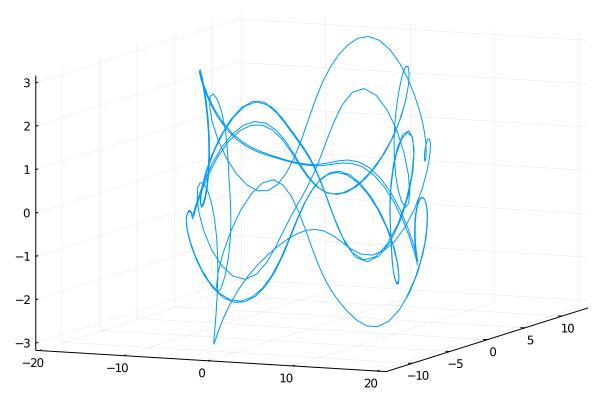

In [6]:
vmecCoords = VmecFromPest()(pestCoords, vmecSurface);
cartCoords = CartesianFromVmec()(vmecCoords, vmecSurface);

X = [q[1] for q in cartCoords];
Y = [q[2] for q in cartCoords];
Z = [q[3] for q in cartCoords];

plot(X, Y, Z, aspect_ratio=:equal, legend=:none)

The above code also demonstrates a feature of the `CoordinateTransformations` package that is adopted here.  The coordinate transformations themselves are defined as singletons (empty structs) that are subtypes of the `Transformation` type defined in `CoordinateTransformations`.  For example, the defintion for `VmecFromPest` is
```julia
struct VmecFromPest <: Transformation end
```

These types can then be used as a trait to differentiate between different transformation types in a function signature, such as the `transform_basis` function used in `CoordinateTransformations` which takes a `Tranformation` type as its first argument:
```julia
function transform_basis(::VmecFromPest,...)
    ...
end
```
We can also make the type callable, as is demonstrated in the above code, but one must be sure to use the non-standard syntax `VmecFromPest()(args)` when calling the transformation function.  This is required as there is only one instatiation of a singleton type, which in this case is `VmecFromPest()`.  One could also alias it with a different symbol, such as `f = VmecFromPest(); f(args...)`, but that obfuscates use in these examples.  If you try to call `VmecFromPest` without the extra `()`, you will get an error:

In [12]:
VmecFromPest(pestCoords,vmecSurface)

LoadError: MethodError: no method matching VmecFromPest(::Vector{PestCoordinates}, ::VmecSurface{4, Float64})

Let's plot another quantity of interest, the magnetic field strength along a field line.  We can use the vmecCoords that we calculated before.

To calculate the real space representation of VMEC quantities, two inverse Transform functions are provided: `inverseCosineTransform` and `inverseSineTransform`.  These functions take a list of coordinates and field from a `VmecSurface` and produce the field value at the specified coordinates.  Note that these transforms are valid *only* on a magnetic surface.  These transforms take advantage of the data layout of the `VmecSurface` field data to very efficiently perform the inverse transform, which is crucial if one desires the real space coordinate information at a large number of points.

We take advantage of the `inverseCosineTransform` function which is used for vmec quantities (like `bmnc`) that have cosine coefficients as their stellarator symmetric coefficients.  Currently, it is up to the user to use the correct inverse transform function.  Future improvements may build in a decorator to the data types to ensure the correct transform is sued.  The calculation can be done in one line.

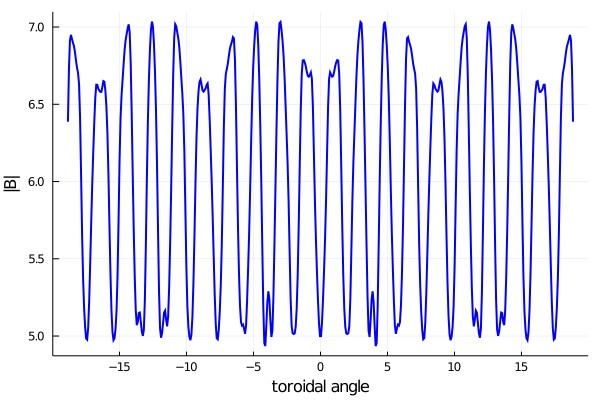

In [9]:
Bmag = [inverseCosineTransform(v, vmecSurface.bmn) for v in vmecCoords];
plot(zetas, Bmag, linewidth=2, linecolor=:blue, label="", xaxis="toroidal angle",
     yaxis="|B|")

Another quantity of interest is the Jacobian given by sqrt(g).  We will do this in two ways, the first is to use the VMEC gmn quantity and the second is to take the triple product of the basis vectors.  First from VMEC  (note that since this is a left-handed coordinate system, the Jacobian is negative)

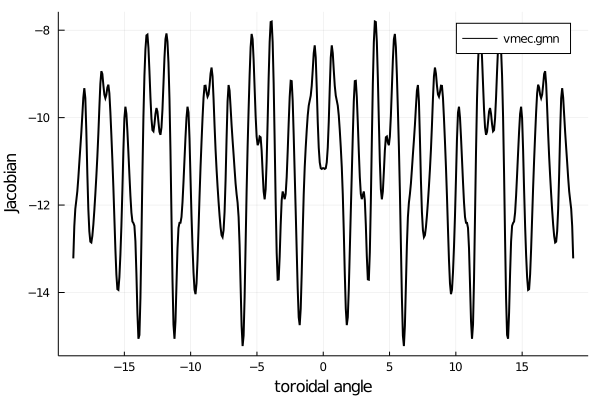

In [10]:
g1 = [inverseCosineTransform(v, vmecSurface.gmn) for v in vmecCoords];
plot(zetas, g1, linewidth=2, linecolor=:black, label = "vmec.gmn", 
    xaxis = "toroidal angle", yaxis = "Jacobian")

Getting basis vectors and doing conversions between different coordinate systems can sometimes be a bit difficult.  Therefore we've tried to simplify these calculations.  

The first line below produces the Cartesian components of the covariant VMEC basis vectors, ($e_s$,$e_{\theta^*}$,$e_\phi$).  The `CartesianFromVmec()` trait is specified as both a reminder that the components of the vectors are the Cartesian components and also to leave the open the possibility of defining the coordinate vector components with respect to a different basis.

The result of `covariant_basis` is a `3x3 SArray{Float64}`, where the first column are the xyz components of $e_s$, the second column the xyz components of $e_{\theta^*}$ and the third column the xyz components of $e_\phi$.

After that we take the triple product and overplot it on the previous to see if they agree.

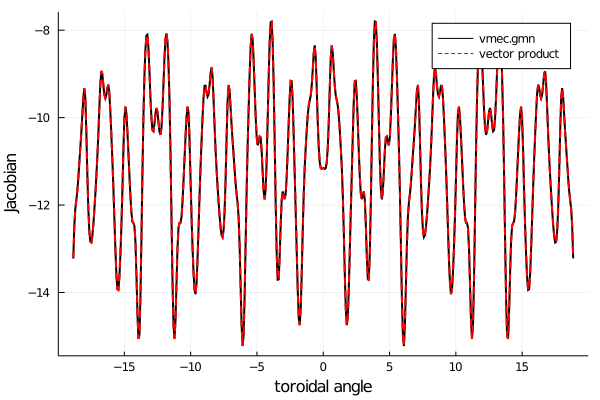

In [11]:
vmecCovariantBasis = covariant_basis(CartesianFromVmec(),vmecCoords,vmecSurface); 
g2 = map(x->dot(x[:,1],cross(x[:,2],x[:,3])),vmecCovariantBasis);
plot!(zetas, g2, linewidth=2, linecolor=:red, linestyle=:dash, label="vector product")

We won't go into all the things that could be plotted, but many derived quantities are readily available. Here we plot both the normal and geodesic curvatures along the field line.

To perform this calculation, the following geometric information is required:
- the Cartesian components of contravariant basis vectors for VMEC coordinates ($\nabla s$,$\nabla \theta^*$,$\nabla \phi$)
- the Cartesian components of the contravariant basis vectors for PEST coordinates ($\nabla \psi$,$\nabla \alpha$,$\nabla \zeta$)
- the Cartesian components of $\nabla B$

The contravariant VMEC basis vectors are computed in the standard way by first converting PEST coordinates to VMEC coordinates and then calling the `contravariant_basis()` function.  The function `transform_basis(PestFromVmec(),...)` uses the `PestFromVmec()` trait as detailed previously and returns the Cartesian components of the PEST basis vectors at each point specified by `pestCoords`.

The calculation for $\nabla B$ is most easily accomplished by computing $\nabla B = \partial B/\partial s \nabla s + \partial B/\partial \theta^* \nabla \theta^* + \partial B/\partial \phi \nabla \phi$, where the deriatves of $B$ are computed from the VMEC equilibrium at each point specifed by `vmecCoords`.  Note that the xyz-components of $\nabla B$ are invariant under the choice of basis vector used in the calculation, thus as long as the Cartesian components of a different set of basis vectors have been computed, the projection of $\nabla B$ is straight forward.

For ease of interpretation we explicitly use a forloop here over zeta

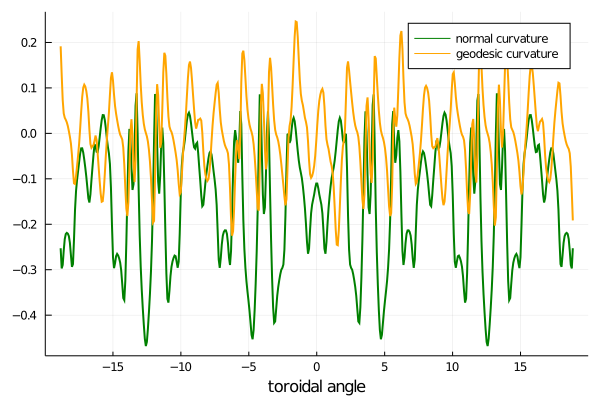

In [13]:
kappag = Vector{Float64}(undef, npoints);
kappan = Vector{Float64}(undef, npoints);

for i = 1:npoints

    #pc = pestCoords[i]
    vc = vmecCoords[i];
    vmecContraBasis = contravariant_basis(CartesianFromVmec(),vc,vmecSurface);
    pestContraBasis = transform_basis(PestFromVmec(),vc, vmecContraBasis, vmecSurface);
    gradB = VMEC.gradB(vc, vmecContraBasis, vmecSurface);
    kappan[i] = curvatureComponents(pestContraBasis, gradB)[1];
    kappag[i] = curvatureComponents(pestContraBasis, gradB)[2];
end

plot(zetas, kappan, linewidth=2, linecolor=:green, label="normal curvature", 
    xaxis="toroidal angle")
plot!(zetas, kappag, linewidth=2, linecolor=:orange, label="geodesic curvature")